# Exploratory data analysis (EDA) of regulated banks

![](fdic_hq.jpeg)

## 1. Data cleaning - analysis of costs of failed banks
The dataset was retrieved on 10/22/2021 using download functionality. It contains information about recently (last 20 years) failed banks, i.e. name of the bank and IDs, date of restructuring and costs. 
* Link: https://www.fdic.gov/resources/resolutions/bank-failures/failed-bank-list/

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### 1.1 Imputing missing values of COSTS
The data set had several issues that required data cleaning and transformation. First, loading the dataset, dropping unused columns and checking missing values.

In [132]:
costs = pd.read_csv('../../data/failed_banks.csv', index_col=0)
costs.drop(['FIN', 'ID', 'RESTYPE1', 'SAVR' ], axis=1, inplace=True)
costs.isnull().sum().sum()

14

It appears that 14 failed banks have NaN for restructuring costs. These missing values can be imputed either with zeros, or column average, or, even better, average % of costs to assets, as restructuring a bigger bank is more expensive. Need to check how these missing values related to the type pf resolution, RESTYPE. As shown below, there are 2 types - ASSISTANCE and FAILURE

In [133]:
costs.groupby([costs['RESTYPE']]).count()

,CHCLASS1,CITYST,COST,FAILDATE,NAME,QBFASSET,QBFDEP
RESTYPE,,,,,,,
ASSISTANCE,13,13,0,13,13,13,13
FAILURE,564,564,563,564,564,564,564


Comparing groupings with missing values. It appears that all 13 ASSISTANCE cases have NaN for COST and thus it is warranted to impute these values with zeros. In other words, assistance is not a failure and there are no direct costs associated with bank's restructuring in this case. There is only one ("NET FIRST NATIONAL BANK") missing value in case of an actual FAILURE and it should probably be imputed with some kind of proxy for COST.

In [134]:
missing_data = costs[costs.isnull().any(axis=1)]
missing_data.groupby([missing_data['RESTYPE']]).count()

,CHCLASS1,CITYST,COST,FAILDATE,NAME,QBFASSET,QBFDEP
RESTYPE,,,,,,,
ASSISTANCE,13,13,0,13,13,13,13
FAILURE,1,1,0,1,1,1,1


Using relative costs seems warranted in this case - need to compute mean of COST / QBFASSET and apply it to the bank's assets to estimate possible restructuring costs. The overall average is around 23%.

In [135]:
avg_CostsToAssets  = np.round(np.mean(costs['COST']/costs['QBFASSET']), 2)
avg_CostsToAssets

0.23

After the COST value was imputed with the multiplier `avg_CostsToAssets`:

In [136]:
costs.iloc[561, 2] = costs.iloc[561, 6] * avg_CostsToAssets
costs.iloc[561, ]

CHCLASS1                          N
CITYST               BOCA RATON, FL
COST                     7268.23000
FAILDATE                 03/01/2002
NAME        NET FIRST NATIONAL BANK
QBFASSET                      37207
QBFDEP                        31601
RESTYPE                     FAILURE
Name: 26652, dtype: object

After this imputation all remaining 13 missing values are associated with assistance RESTYPE and thus should have zero COST, i.e. one can impute these missing values with zeros.

In [137]:
costs[costs.isnull().any(axis=1)].groupby("RESTYPE").count()

,CHCLASS1,CITYST,COST,FAILDATE,NAME,QBFASSET,QBFDEP
RESTYPE,,,,,,,
ASSISTANCE,13,13,0,13,13,13,13


In [138]:
costs['COST'].replace(np.nan, 0, inplace=True)

The resulting DataFrame `costs` does not have any missing values.

In [139]:
costs.isnull().sum().sum()

0

### 1.2 Converting and splitting FAILDATE
Column FAILDATE has information about when the bank has failed, it needs to be converted to `datetime` object and preferably split into for time series analysis.

In [141]:
costs['DATE'] = pd.to_datetime(costs['FAILDATE'])
costs.drop('FAILDATE', axis=1, inplace=True)

Split the DATE column so that information about the year and month of failure are stored in separate columns. 

In [143]:
costs['YEAR_FAILED'] = costs['DATE'].dt.year.astype('Int64')
costs['MONTH_FAILED'] = costs['DATE'].dt.month.astype('Int64')
costs['QUARTER_FAILED'] = pd.PeriodIndex(costs.DATE, freq='Q')

### 1.3 Plotting distribution and cumsum of COSTS

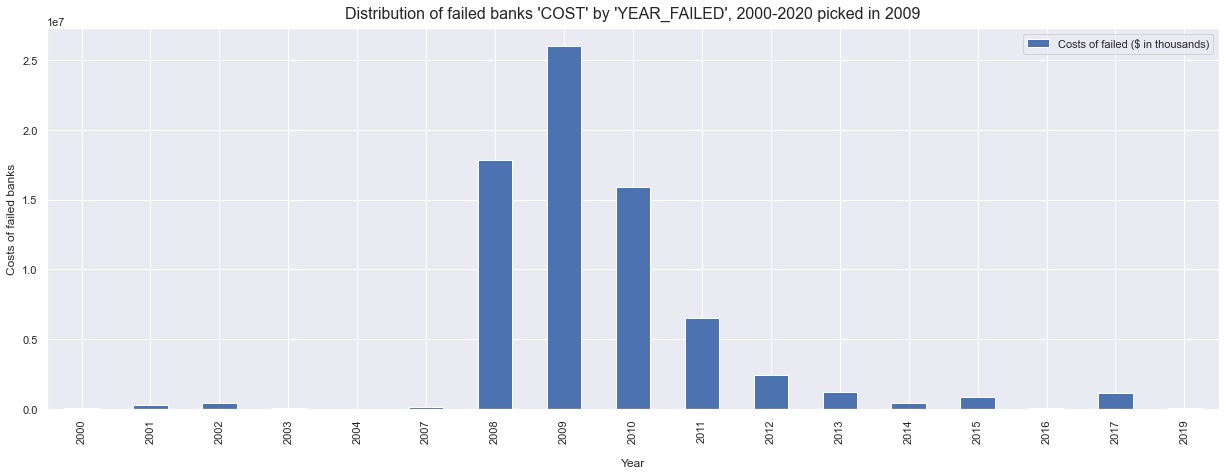

In [145]:
costs.groupby(['YEAR_FAILED'])['COST'].sum().plot(kind='bar',
                                               figsize=(21, 7),
                                               label='Costs of failed ($ in thousands)')
plt.title("Distribution of failed banks 'COST' by 'YEAR_FAILED' (2000-2020) picked in 2009", y=1.01, fontsize=16)
plt.ylabel("Costs of failed banks", labelpad=5)
plt.xlabel("Year", labelpad=15)
plt.legend()
plt.show()

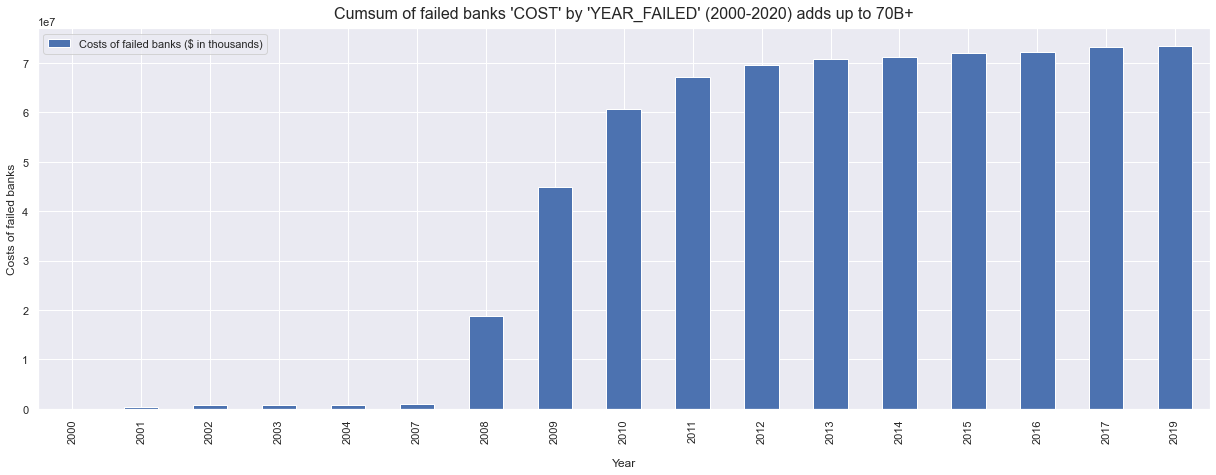

In [146]:
costs.groupby(costs['YEAR_FAILED'])['COST'].sum().cumsum(axis=0).round(2).plot(
kind='bar', figsize=(21, 7), label="Costs of failed banks ($ in thousands)")
plt.title("Cumsum of failed banks 'COST' by 'YEAR_FAILED' (2000-2020) adds up to 70B+", y=1.01, fontsize=16)
plt.ylabel("Costs of failed banks", labelpad=5)
plt.xlabel("Year", labelpad=15)
plt.legend()
plt.show()

## 2. Data processing - retrieving all regulatory reports
All regulated banks submit quarterly reports to Federal Financial Institutions Examination Council (FFIEC). These data is aggregated and made available to general public via SOAP APIs. Executing sequential  `retrieve_filers_since_date` calls allows rebuilding the universe (population) of regulated banks as it existed at a specific filing date.
* Link: https://cdr.ffiec.gov/public/PWS/PWSPage.aspx
* Link: https://cdr.ffiec.gov/public/HelpFileContainers/PWSInfo.aspx

### 2.1 Connecting to the server
`FFIEC_Client` is a wrapper class written to extend functionality of a standard `zeep` SOAP APIs client. It was developed and tested in a separate .py file, imported here. All credit goes to Ryan Arredondo (ryan.c.arredondo@gmail.com) as he is the original author to the best of our knowledge.

The actual connection to the server can be done manually by entering login credentials or using the hard coded values below in the next section. FFIEC only allows a limited number of daily calls and discourages using someone else's credentials; provided for testing demonstration purposes only. 

In [370]:
from ffipy import FFIEC_Client
from io import StringIO
from zeep.wsse.username import UsernameToken
import unittest
import warnings
warnings.filterwarnings("ignore")

In [371]:
client = FFIEC_Client()

In [372]:
client.test_user_access()

True

### 2.2 Testing reporting database client
The section below performs several unit tests on the remote server to check if the data did not change since the last retrieval.

In [373]:
wsdl = \
    'https://cdr.ffiec.gov/Public/PWS/WebServices/RetrievalService.asmx?WSDL'
username = 'dmikhaylov2021'
password = 'zVu5W3tw4U2KAH8IeR7z'
wsse = UsernameToken(username, password)
client = FFIEC_Client(wsse=(username, password))

class API_client_rest(unittest.TestCase):
    
# Test if still connected
    def test_connected(self):
        self.assertTrue(client.test_user_access())

# Test end of the period count
    def test_end_period_count(self, date='12/31/2019', count=5227):
        self.assertEqual(len(client.retrieve_panel_of_reporters(
            ds_name='Call', reporting_pd_end=date)), count)

# Test start of the period count
    def test_start_period_count(self, date='12/31/2001', count=8689):
        self.assertEqual(len(client.retrieve_panel_of_reporters(
            ds_name='Call', reporting_pd_end=date)), count)
    
# Test name of the bank
    def test_reporting_periods(self, report_type='Call', periods=83):
        self.assertEqual(len(client.retrieve_reporting_periods(ds_name=report_type)), periods)

if __name__ == "__main__":

  unittest.main(argv=[''], exit=False)

./Users/dmitrymikhaylov/opt/anaconda3/lib/python3.8/site-packages/zeep/xsd/elements/element.py:153: ResourceWarning:

unclosed <ssl.SSLSocket fd=67, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.20.11.237', 58807)>

/Users/dmitrymikhaylov/opt/anaconda3/lib/python3.8/site-packages/zeep/xsd/elements/element.py:153: ResourceWarning:

unclosed <ssl.SSLSocket fd=83, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.20.11.237', 58954)>

/Users/dmitrymikhaylov/opt/anaconda3/lib/python3.8/site-packages/zeep/xsd/elements/element.py:153: ResourceWarning:

unclosed <ssl.SSLSocket fd=85, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.20.11.237', 58955)>

/Users/dmitrymikhaylov/opt/anaconda3/lib/python3.8/site-packages/zeep/xsd/elements/element.py:153: ResourceWarning:

unclosed <ssl.SSLSocket fd=86, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('172.20.11.237', 58963)>

/Us

### 2.3 Comparing failed and surviving banks
Get the number of regulator reports submitted by the banks and compare the number of surviving banks to the number of failed banks at the end of the same period. 

First, get the list of years for which there are costs of failures data. After that, make API calls for end of these years to check how many banks submitted the reports. Store the results on `regulated_universe` dictionary. This may take several minutes to run.

In [202]:
years = costs['YEAR_FAILED'].unique()
regulated_universe = {}
for year in years:
    reporting_date = '12/31/'+str(year)
    try:
        regulated_universe[year]=len(client.retrieve_panel_of_reporters(ds_name='Call', 
                                                                        reporting_pd_end=reporting_date))
    except:
        regulated_universe[year] = 0
regulated_universe

{2019: 5227,
 2017: 5721,
 2016: 5966,
 2015: 6238,
 2014: 6570,
 2013: 6877,
 2012: 7150,
 2011: 6789,
 2010: 6999,
 2009: 7321,
 2008: 7569,
 2007: 7788,
 2004: 8179,
 2003: 8348,
 2002: 8468,
 2001: 8689,
 2000: 0}

Code below stores information about failed and active, i.e. surviving or reporting, banks in a single DataFrame object for the purposes of visualization and analysis. First, `groupby` selection of annual failed banks is converted to a separate table `failed_counts`, sorted, and columns renamed. Second, `active_counts` table is produced from the `regulated_universe` dictionary returned by API client. Finally, both tables are merged on column "Year" for further analysis.

In [377]:
failed_counts = costs.groupby(costs['YEAR_FAILED'])['COST'].count().reset_index().rename(
    columns={'YEAR_FAILED':'Year', 'COST':'Failed'})
failed_counts.sort_values('Year', ascending=True, inplace=True)

active_counts = pd.DataFrame.from_dict(regulated_universe, orient='index', columns=['Active']).reset_index()
active_counts.sort_values('index', ascending=True, inplace=True)

banks_counts = pd.merge(active_counts, failed_counts, how="inner", on=failed_counts['Year'])

Below is a summary plot that shows annual counts of failed banks stacked on top of active banks. Please note that y-axis was adjust for a range starting at 4000 counts to make failed banks appear more pronounced.

Still, bank failures is a very rare event that obviously can't explain why the number of regulated banks declined from almost 9,000 down to slightly more than 5,000. Additional analysis is warranted to help understand the drivers of this drastic change.

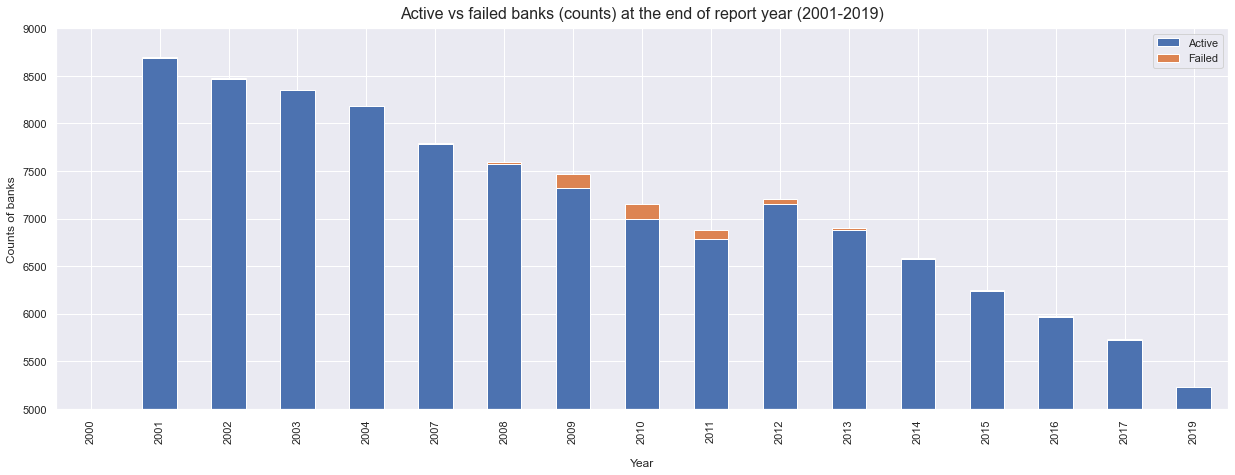

In [388]:
banks_counts.plot(x='Year', 
                  y=['Active', 'Failed'], 
                  kind='bar', 
                  stacked=True, 
                  figsize=(21, 7))

plt.legend()
plt.title("Active vs failed banks (counts) at the end of report year (2001-2019)", y=1.01, fontsize=16)
plt.ylabel("Counts of banks", labelpad=5)
plt.xlabel("Year", labelpad=15)
plt.ylim([5000, 9000])
plt.show()

## 3. Data analysis - explaining industry consolidation 
FDIC maintains BankFind Suite portal, which is effectively events and changes database. Although it does not redirect to the corresponding statutory reports, it provides summary information about major corporate events, such as mergers or charter changes.
- Link: https://banks.data.fdic.gov/bankfind-suite/oscr

In [291]:
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "seaborn"

### 3.1 HOW MUCH TO EXPLAIN AT THIS POINT REGARDING OUR RECONCILIATION EFFORTS???

### 3.2 Summary waterfall chart
This chart is a querying tool as well. It not only gives a high level view of the industry consolidation throughout the years but also allows to do visual analysis of the data by zooming into desired flows and periods. use 'Reset axes' to go back to the original view.

In [384]:
data = pd.read_csv('../../data/WaterFall_Data_Commercial.csv', index_col=0)
x = data['Category']
y = data['Value']
measure = data['Measure Type']
fig = go.Figure(go.Waterfall(measure=measure, x=x, y=y))
fig.update_layout(title="Commercial banks consolitation 2000-2020",
                  xaxis = go.layout.XAxis(tickangle = 270))
fig.update_yaxes(range=[4000, 8500])

## Conclusions future improvements